In [1]:
import numpy as np
from PQmodel import PQ 
import matplotlib.pylab as plt
from stockwell import st
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from Tools import *



In [2]:
catalog=['Pure sinusoidal', 'Sag', 'Swell','Interruption','Transient/Impulse/Spike',
         'Oscillatory transient','Harmonics','Harmonics with Sag', 'Harmonics with Swell',
         'Flicker', 'Flicker with Sag', 'Flicker with Swell', 'Sag with Oscillatory transient',
         'Swell with Oscillatory transient', 'Sag with Harmonics', 'Swell with Harmonics', 'Notch',
         'Harmonics with Sag with Flicker', 'Harmonics with Swell with Flicker',  'Sag with Harmonics with Flicker',
         'Swell with Harmonics with Flicker', 'Sag with Harmonics with Oscillatory transient',
         'Swell with Harmonics with Oscillatory transient', 'Harmonics with Sag with Oscillatory transient',
         'Harmonics with Swell with Oscillatory transient','Harmonics with Sag with Flicker with Oscillatory transient',
         'Harmonics with Swell with Flicker with Oscillatory transient', 'Sag with Harmonics with Flicker with Oscillatory transient',
         'Swell with Harmonics with Flicker with Oscillatory transient']

In [3]:
ciclos = 10
freq =60
fs =3600
mpc= fs/freq
Model = PQ(Cicles=ciclos,FS=fs,Frecuency=freq,InicioDisturbio=0,PeriodoDisturbio=5)
t = np.linspace(0,ciclos/freq,int(mpc*ciclos))

In [4]:
Signal_List = [1,2,3,4,5,6,9,16] #[1,2,3,4,5]#
Sig_names = list(np.array(catalog)[Signal_List])
Signas_perEvent=50
a = Model.PQselectivo(Signas_perEvent,Signal_List)


In [5]:
data,y=build_data(a,t)
n_signals=len(Signal_List)
data=data.reshape(n_signals*Signas_perEvent,6,int(mpc*ciclos),1)
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=42)


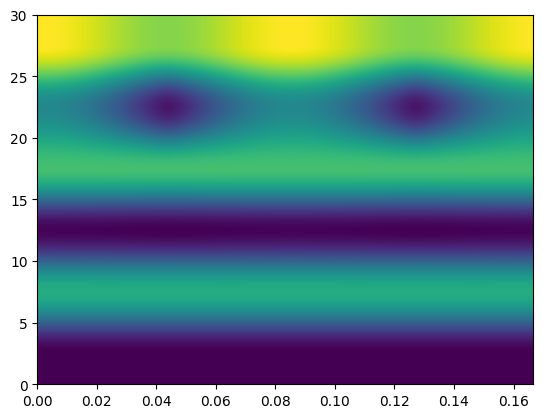

In [6]:
extent = (t[0], t[-1], 0, 30)
plt.imshow(abs(data[1,:]), origin='lower',extent=extent)
plt.axis('tight')
plt.show()

In [7]:
# Crear un modelo secuencial
model = Sequential()

# Capa de convolución con 64 filtros de 3x3, activación ReLU
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(6,600,1)))

# Capa de convolución con 128 filtros de 3x3, activación ReLU
model.add(Conv2D(128, (3, 3), activation='relu'))

# Capa de Max Pooling 2D
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de Flatten para convertir los mapas de características en un vector unidimensional
model.add(Flatten())

# Capa completamente conectada con 64 neuronas y activación ReLU
model.add(Dense(64, activation='relu'))

# Capa de salida con activación softmax para la clasificación
model.add(Dense(n_signals, activation='softmax'))  # Aquí n_signals es el número de clases

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 598, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 596, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 298, 128)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 38144)             0         
                                                                 
 dense (Dense)               (None, 64)                2441280   
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                        

In [8]:
history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=100)#,validation_data=(X_val, y_val))

Epoch 1/150
4/4 [==============================] - 8s 120ms/step - loss: 2.0583 - accuracy: 0.1344
Epoch 2/150
4/4 [==============================] - 0s 31ms/step - loss: 1.9187 - accuracy: 0.2156
Epoch 3/150
4/4 [==============================] - 0s 27ms/step - loss: 1.8401 - accuracy: 0.1750
Epoch 4/150
4/4 [==============================] - 0s 31ms/step - loss: 1.7530 - accuracy: 0.3031
Epoch 5/150
4/4 [==============================] - 0s 29ms/step - loss: 1.6682 - accuracy: 0.3344
Epoch 6/150
4/4 [==============================] - 0s 30ms/step - loss: 1.5666 - accuracy: 0.3125
Epoch 7/150
4/4 [==============================] - 0s 29ms/step - loss: 1.5101 - accuracy: 0.3000
Epoch 8/150
4/4 [==============================] - 0s 26ms/step - loss: 1.4468 - accuracy: 0.3406
Epoch 9/150
4/4 [==============================] - 0s 27ms/step - loss: 1.5194 - accuracy: 0.2937
Epoch 10/150
4/4 [==============================] - 0s 31ms/step - loss: 1.4289 - accuracy: 0.3344
Epoch 11/150
4/4 [

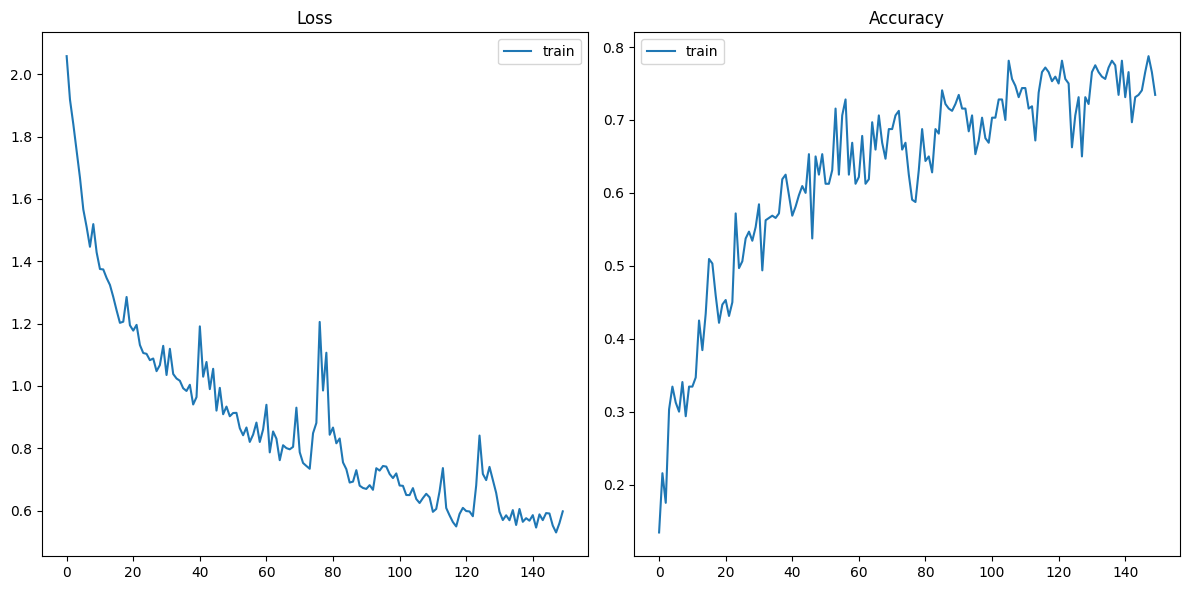

In [9]:
# Mostrar la pérdida y la precisión durante el entrenamiento
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
prediccion= model.predict(X_val)

3/3 [==============================] - 0s 45ms/step


In [11]:
def CrearCMdata(resultad,Muestras,Clases):
    yp,y=[],[]
    u=0
    for k in range(Muestras):
        for v in range(Clases):
            y.append(v)
            yp.append(list(resultad[u]).index(np.max(resultad[u])))
            u=u+1
    return np.array(y),np.array(yp)

In [12]:
pd,y_v = CrearCMdata(prediccion,10,n_signals)



In [13]:
f1 = f1_score(y_v, pd, average=None)  # Puedes elegir 'macro', 'micro' o 'weighted'
print("F1-score (micro-average):", f1)

# También puedes imprimir un reporte detallado que incluya precision, recall y F1-score por clase
report = classification_report(y_v, pd)
print("Reporte de clasificación:")
print(report)

F1-score (micro-average): [0.08695652 0.         0.13333333 0.         0.10526316 0.
 0.16666667 0.18181818]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.10      0.08      0.09        13
           1       0.00      0.00      0.00         0
           2       0.20      0.10      0.13        20
           3       0.00      0.00      0.00         2
           4       0.10      0.11      0.11         9
           5       0.00      0.00      0.00        10
           6       0.20      0.14      0.17        14
           7       0.20      0.17      0.18        12

    accuracy                           0.10        80
   macro avg       0.10      0.07      0.08        80
weighted avg       0.14      0.10      0.12        80



c:\Users\micke\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\micke\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\micke\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


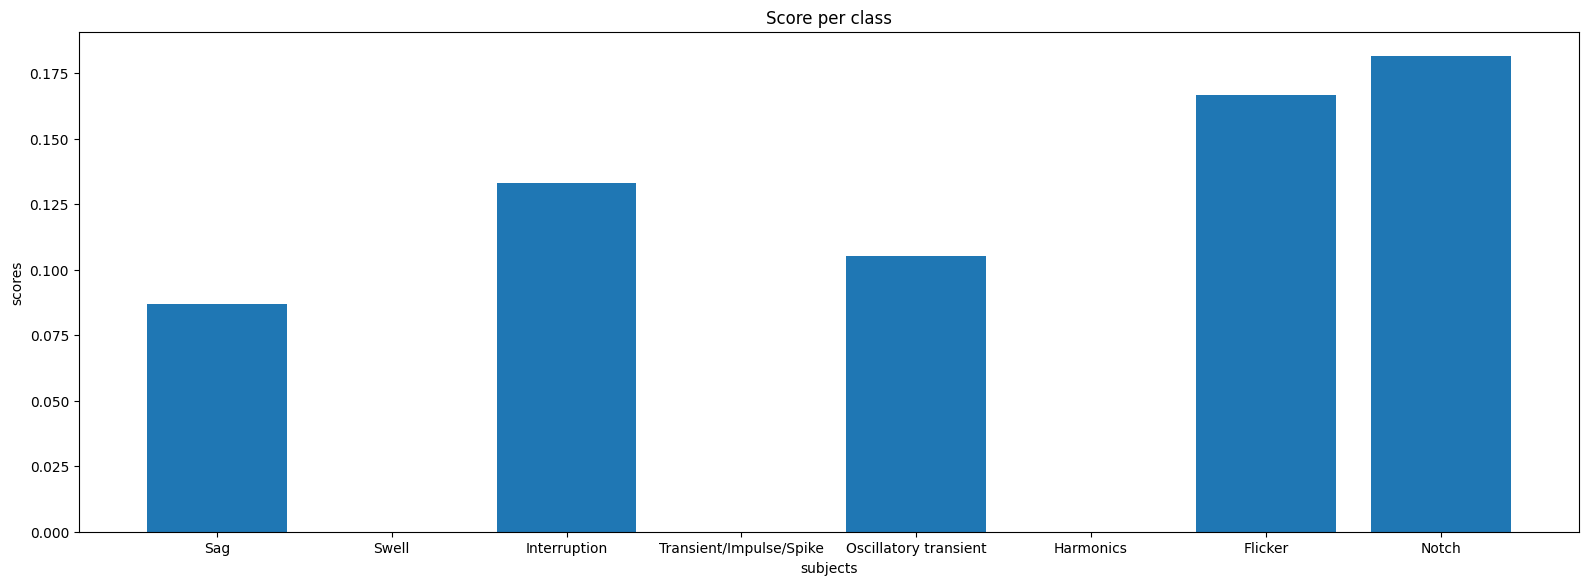

In [14]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(Sig_names,f1)
ax.set_ylabel('scores')
ax.set_xlabel('subjects')
ax.set_title('Score per class')

plt.savefig('Figures/barplot_CNN2D.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

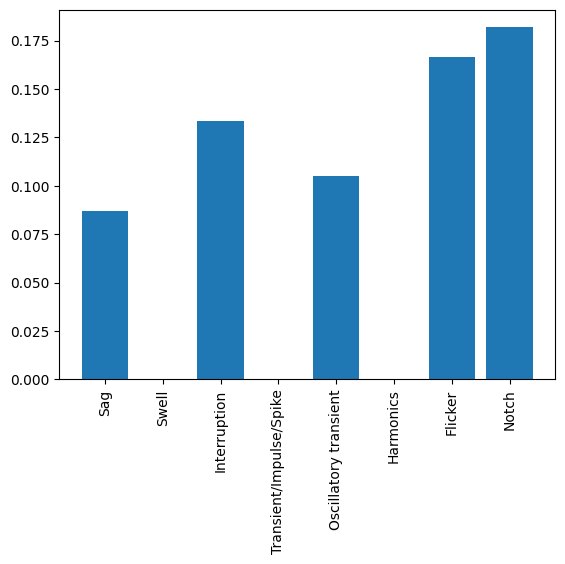

In [15]:
y_pos = range(len(Sig_names))
plt.bar(y_pos, f1)
plt.xticks(y_pos, Sig_names, rotation=90)
plt.show()

Example

In the following code it shows how to use a stockwell transform. You can see how to install stockwell library in https://pypi.org/project/stockwell/1.0/ and a brief summary how to use it

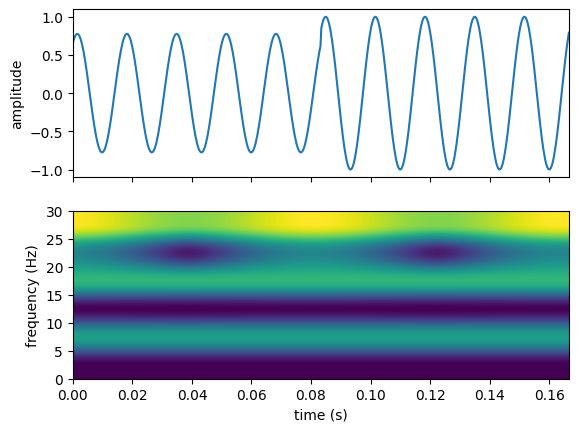

In [16]:
m=0
t = np.linspace(0,1/6,600)
df = 1/(t[-1]-t[0])  # sampling step in frequency domain (Hz)
fmin=0
fmax=30
stock = st.st(a[m,0], int(fmin/df), int(fmax/df))
extent = (t[0], t[-1], fmin, fmax)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, a[m,0])
ax[0].set(ylabel='amplitude')
ax[1].imshow(np.abs(stock), origin='lower', extent=extent)
ax[1].axis('tight')
ax[1].set(xlabel='time (s)', ylabel='frequency (Hz)')
plt.show()

In [17]:
#h=a[m,0]
intex=argrelextrema(a[m,0],np.greater)
intexmin=argrelextrema(a[m,0],np.less)
#intex =np.r_[True, h[1:] < h[:-1]] & np.r_[h[:-1] < h[1:], True]

In [18]:
min(a[m,0][intex])

0.7756040951340486

In [19]:
Zc=np.where(np.diff(np.sign(a[m,0])))[0]

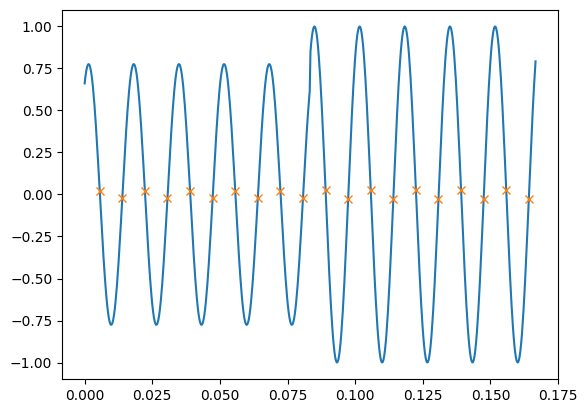

In [20]:
plt.plot(t,a[m,0])
plt.plot(t[Zc],a[m,0][Zc],'x')

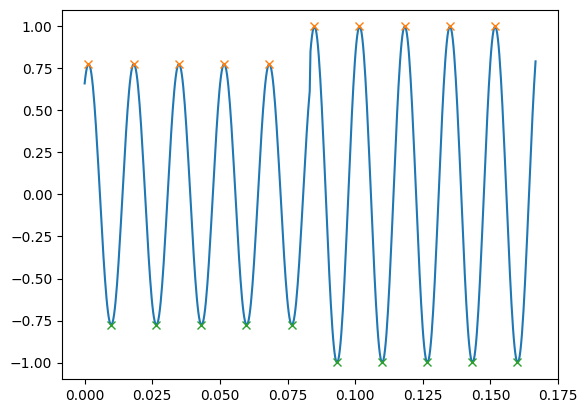

In [21]:
plt.plot(t, a[m,0])
plt.plot(t[intex],a[m,0][intex],'x')
plt.plot(t[intexmin],a[m,0][intexmin],'x')

In [22]:
from scipy.signal import find_peaks

In [23]:
peaks, _ = find_peaks(a[m,0], height=0)

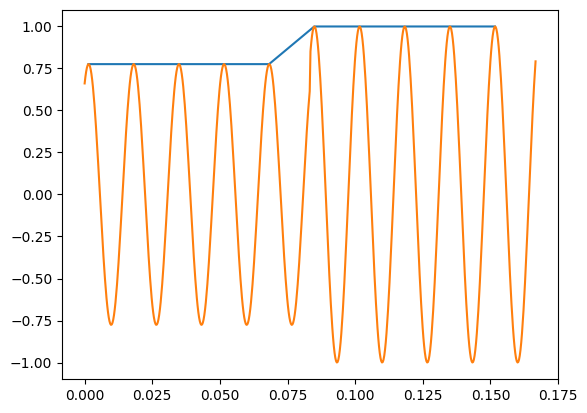

In [24]:
plt.plot(t[peaks],a[m,0][peaks])
plt.plot(t,a[m,0])